# Run the sampler when using a marginalised P1D posterior

We shouldn't be recycling the likelihood object when using the marginalised results, since they shouldn't need to know about the "data", or the nuisance parameters. It should be a separate object, like the CMB likelihood. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
from chainconsumer import ChainConsumer
# our own modules
from lace_manager.data import data_MPGADGET
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace_manager.likelihood import likelihood
from lace_manager.likelihood import marg_p1d_like
from lace_manager.sampler import emcee_sampler
import time

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify emulator type
emu_type="polyfit"

In [3]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [4]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
z_max=4.5
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                sim_label=test_sim_label,
                                zmax=z_max,polyfit=(emu_type=="polyfit"))

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00


### Emulator and training set

Create a set of training data to train an emulator

In [5]:
# Set up emulator training set
archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,z_max=z_max,
                            drop_tau_rescalings=True,drop_temp_rescalings=True)

In [6]:
use_nyx=False
if use_nyx:
    from lace.emulator import p1d_archive_Nyx
    archive=p1d_archive_Nyx.archiveP1D_Nyx(fname=None,verbose=False)

In [7]:
## Build emulator
if use_nyx:
    paramList=['mF', 'sigT_Mpc', 'gamma', 'Delta2_p', 'n_p']
    kmax_Mpc=2
else:
    paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
    kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type=emu_type,passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.25 seconds


### Set up the marginalised P1D likelihood


will setup marg_p1d from KDE file /Users/font/Projects/LaCE_manager/notebooks/example_kde.npz
read KDE from file /Users/font/Projects/LaCE_manager/notebooks/example_kde.npz
will divide by max prob = 6442.674869505908


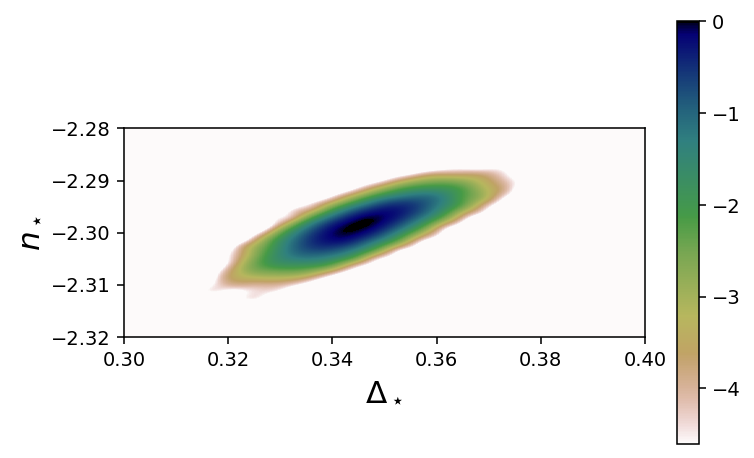

In [8]:
# setup KDE version
kde_fname='/Users/font/Projects/LaCE_manager/notebooks/example_kde.npz'
kde_marg_p1d=marg_p1d_like.MargP1DLike(kde_fname=kde_fname)
kde_marg_p1d.plot_log_like(min_Delta2_star=0.3,max_Delta2_star=0.4)

will setup Gaussian marg_p1d


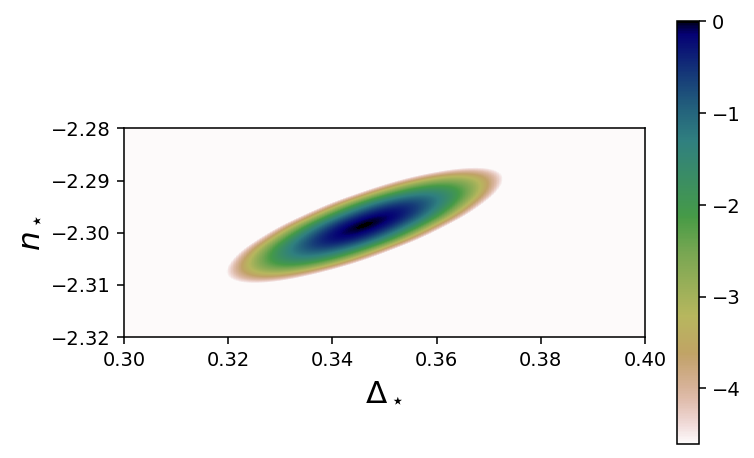

In [9]:
# setup Gaussian version
gauss_marg_p1d=marg_p1d_like.MargP1DLike(sim_label=data.sim_label,reduced_IGM=True,polyfit=data.polyfit)
gauss_marg_p1d.plot_log_like(min_Delta2_star=0.3,max_Delta2_star=0.4)

### Set actual likelihood object (with marginalised P1D)

Here we chose which parameters we want to sample, over which range and chose a prior.

In [10]:
free_param_limits=[[1.1e-09, 3.19e-09], [0.89, 1.05]]
free_param_names=["As","ns"]
prior=0.1

In [11]:
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_param_names=free_param_names,
                            free_param_limits=free_param_limits,
                            prior_Gauss_rms=prior,
                            use_compression=3,
                            marg_p1d=kde_marg_p1d,
                            include_CMB=False)

set marginalised P1D likelihood


### Sampler object

Here we configure our sampler, set the number of walkers, and decide whether or not we want to save the chain to be resumed or plot later on.

In [12]:
## Set up sampler
sampler = emcee_sampler.EmceeSampler(like=like,verbose=False,
                        nwalkers=20,
                        save_chain=False, ## Small test run, don't create a save folder
                        progress=True)

In [13]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

As 2.1e-09 1.1e-09 3.19e-09
ns 0.965 0.89 1.05


In [14]:
n_burn_in=50
n_steps=500 ## Max number of steps to run

start = time.time()
sampler.run_sampler(n_burn_in,n_steps,parallel=False)
end = time.time()
sampler_time = end - start
print("Sampling took {0:.1f} seconds".format(sampler_time))

100%|██████████████████████████████████████| 550/550 [00:10<00:00, 54.93it/s]

Sampling took 10.1 seconds


will keep 10000 \ 10000 points from chain


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/lace_manager-1.0.1-py3.8.egg/lace_manager/sampler/emcee_sampler.py:883: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


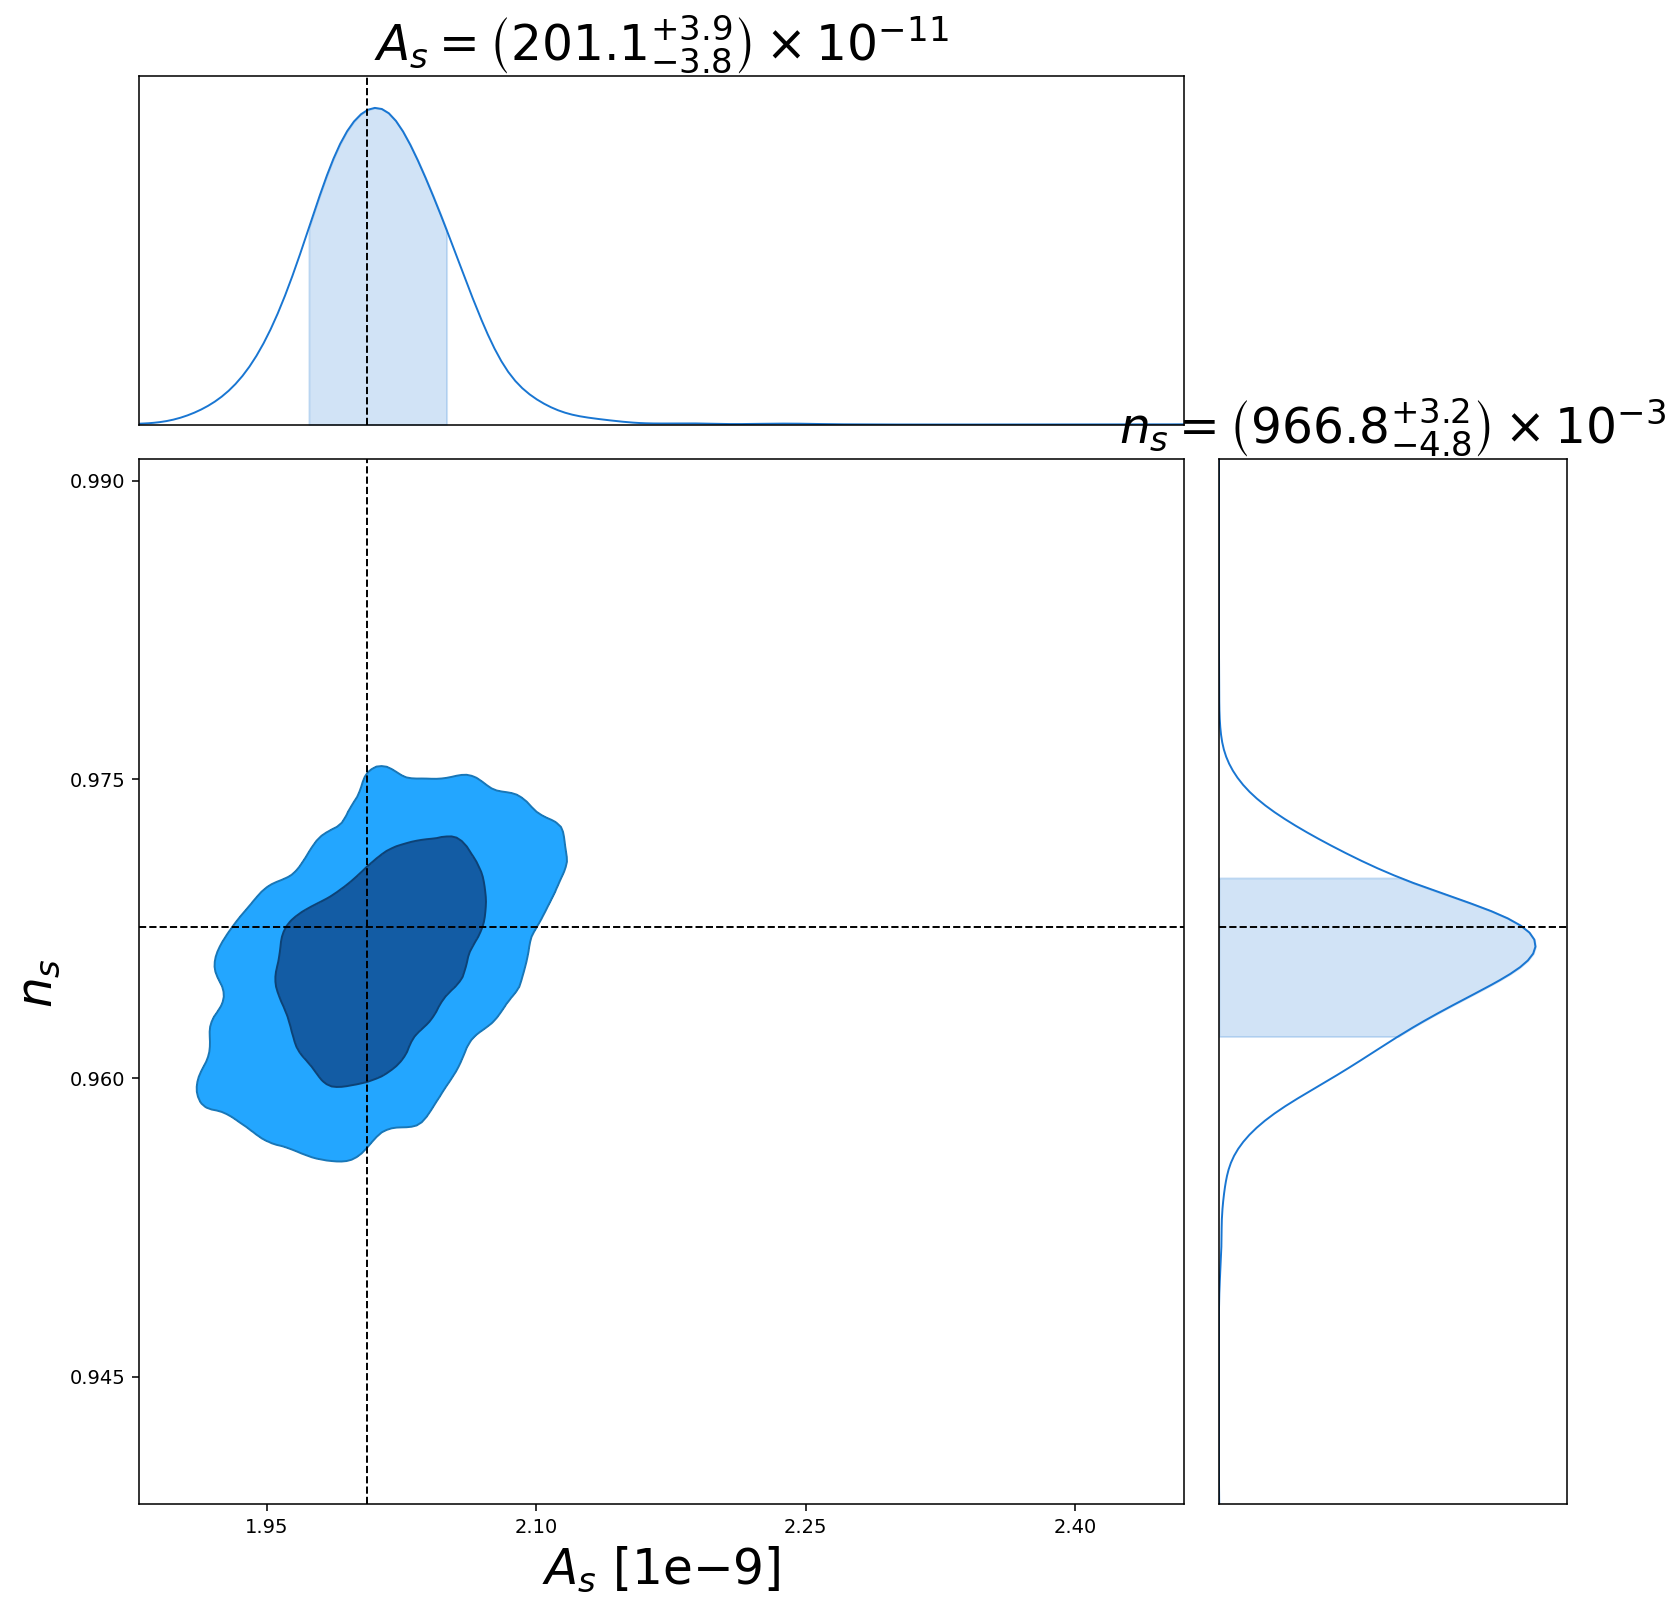

In [15]:
sampler.plot_corner(cmb_prior=False,delta_lnprob_cut=50,
                    plot_params=['$A_s$','$n_s$'],usetex=False,serif=False)

will keep 10000 \ 10000 points from chain


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/lace_manager-1.0.1-py3.8.egg/lace_manager/sampler/emcee_sampler.py:883: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


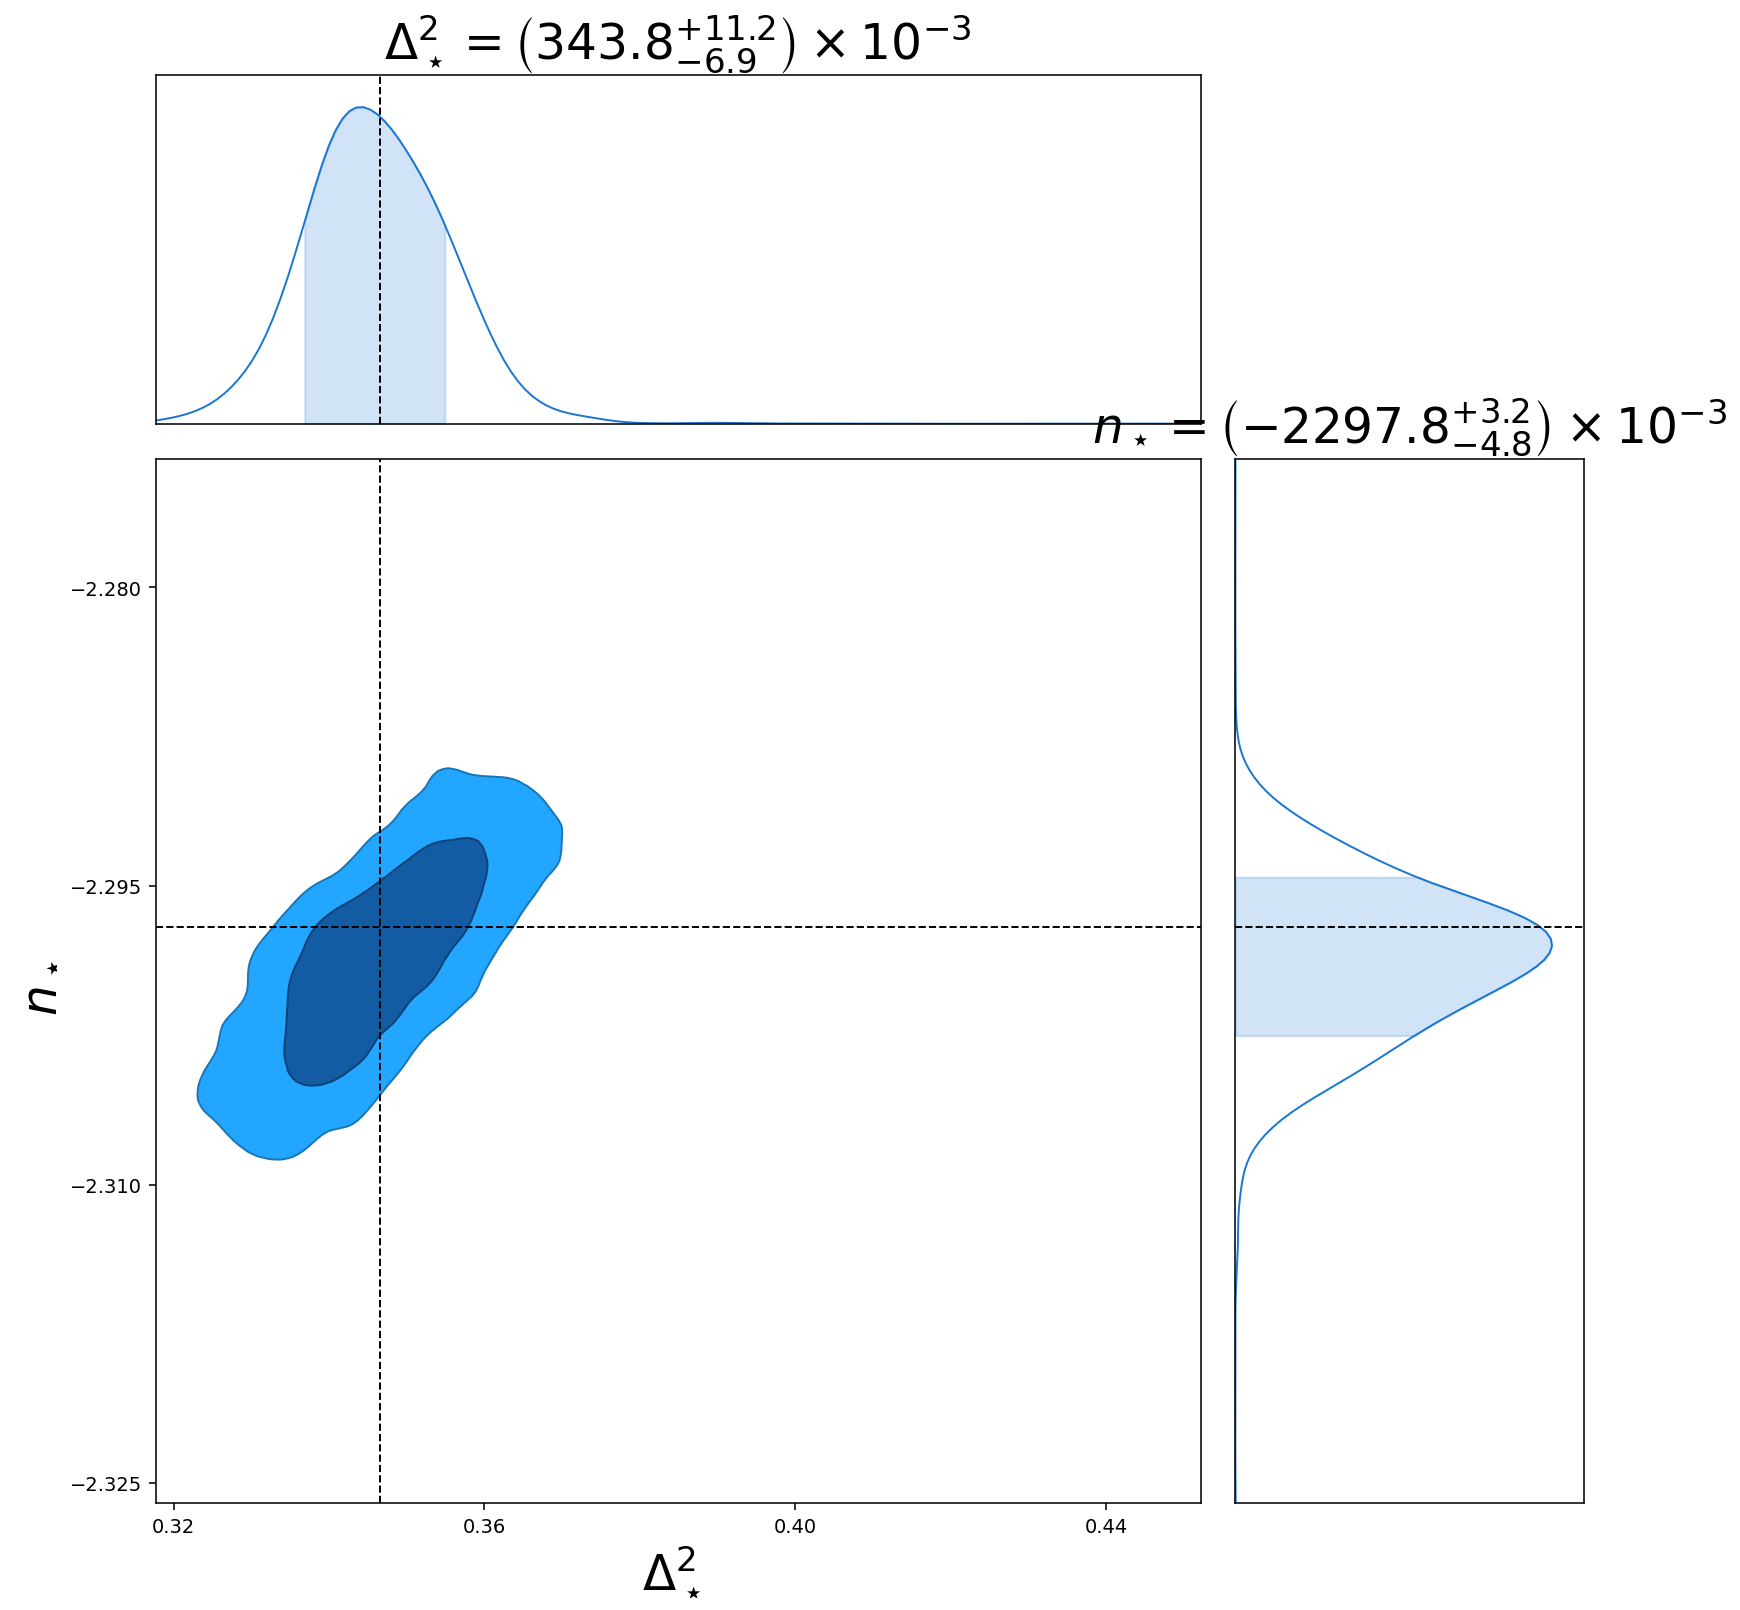

In [16]:
sampler.plot_corner(cmb_prior=False,delta_lnprob_cut=50,
                    plot_params=['$\\Delta^2_\\star$','$n_\\star$'],usetex=False,serif=False)

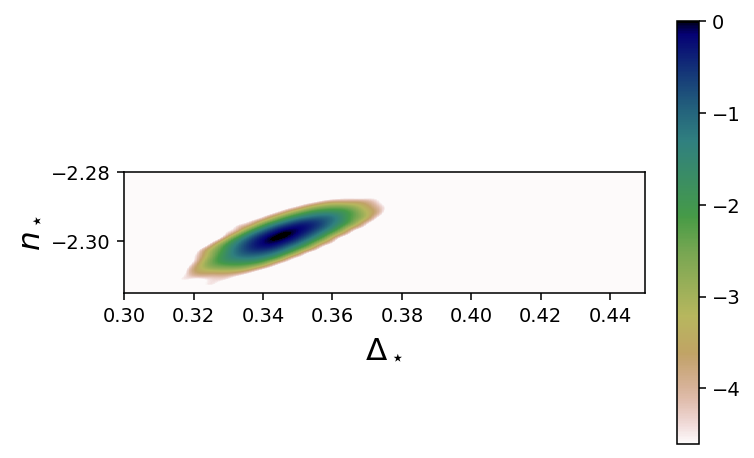

In [17]:
kde_marg_p1d.plot_log_like(min_Delta2_star=0.3,max_Delta2_star=0.45,min_n_star=-2.315,max_n_star=-2.28)